In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from copy import deepcopy

# SciPy for statistical analysis
from scipy import stats
from scipy.stats import t

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
)
from sklearn.metrics import precision_recall_curve


import matplotlib.pyplot as plt


from sklearn.utils import resample, class_weight
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Make sure RandomForestClassifier is imported
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split


# TensorFlow and Keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K

# SHAP for explainability
import shap

# Import seaborn for plotting
import seaborn as sns

# Import plot_tree from sklearn for visualizing trees
from sklearn.tree import plot_tree

In [2]:
# ===========================
# Load and preprocess dataset
# ===========================

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/Shared drives/ABCD_Model/for_JS_final_withgroup.csv'
df = pd.read_csv(file_path)


# Extract numeric site ID from 'site_id_l.baseline_year_1_arm_1'
df['site'] = df['site_id_l.baseline_year_1_arm_1'].str.extract(r'(\d+)$').astype(int)

# Define features for each timepoint
features_baseline = [
    'interview_age.baseline_year_1_arm_1',
    'KSADSintern.baseline_year_1_arm_1',
    'nihtbx_cryst_agecorrected.baseline_year_1_arm_1',
    'ACEs.baseline_year_1_arm_1',
    'avgPFCthick_QA.baseline_year_1_arm_1',
    'rsfmri_c_ngd_cgc_ngd_cgc_QA.baseline_year_1_arm_1',
    'rsfmri_c_ngd_dt_ngd_dt_QA.baseline_year_1_arm_1'
]

features_followup = [
    'interview_age.2_year_follow_up_y_arm_1',
    'KSADSintern.2_year_follow_up_y_arm_1',
    'nihtbx_cryst_agecorrected.2_year_follow_up_y_arm_1',
    'ACEs.2_year_follow_up_y_arm_1',
    'avgPFCthick_QA.2_year_follow_up_y_arm_1',
    'rsfmri_c_ngd_cgc_ngd_cgc_QA.2_year_follow_up_y_arm_1',
    'rsfmri_c_ngd_dt_ngd_dt_QA.2_year_follow_up_y_arm_1',
]

features_all_time = features_baseline + features_followup

# Define cross-sectional features: all other numeric columns not in features_all_time or site/group columns
cross_sectional_features = [
    'rel_family_id',
    'demo_sex_v2',
    'race_ethnicity',
    'acs_raked_propensity_score',
    'speechdelays',
    'motordelays',
    'fam_history_8_yes_no',
    ]
# ========================
# Clean data
# ========================



for col in features_all_time + cross_sectional_features:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col] == '', col] = np.nan
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 2: Drop rows with missing values in key column(s)
df.dropna(subset=features_all_time + ['group_PDvLP_3timepoint'], inplace=True)

# Step 3: KNN Imputation on features (assumes all are numeric now)
#imputer = KNNImputer(n_neighbors=5) #comment these two lines for non data imputation
#df[features_all_time + cross_sectional_features] = imputer.fit_transform(df[features_all_time + cross_sectional_features])

print(f"Total samples after cleaning: {len(df)}")
print(f"1s: {len(df[df['group_PDvLP_3timepoint'] == 1])} 0s: {len(df[df['group_PDvLP_3timepoint'] == 0])}")
site_ids = df['site'].unique()



Mounted at /content/drive
Total samples after cleaning: 4153
1s: 160 0s: 3993


In [3]:
# Rename baseline features
df_renamed = df.copy()
df_renamed = df_renamed.rename(columns={
    col: col.replace('.baseline_year_1_arm_1', '_t0') for col in features_baseline
})
df_renamed = df_renamed.rename(columns={
    col: col.replace('.2_year_follow_up_y_arm_1', '_t1') for col in features_followup
})

# Rebuild flattened feature list
flattened_features = [
    col.replace('.baseline_year_1_arm_1', '_t0') for col in features_baseline
] + [
    col.replace('.2_year_follow_up_y_arm_1', '_t1') for col in features_followup
] + cross_sectional_features


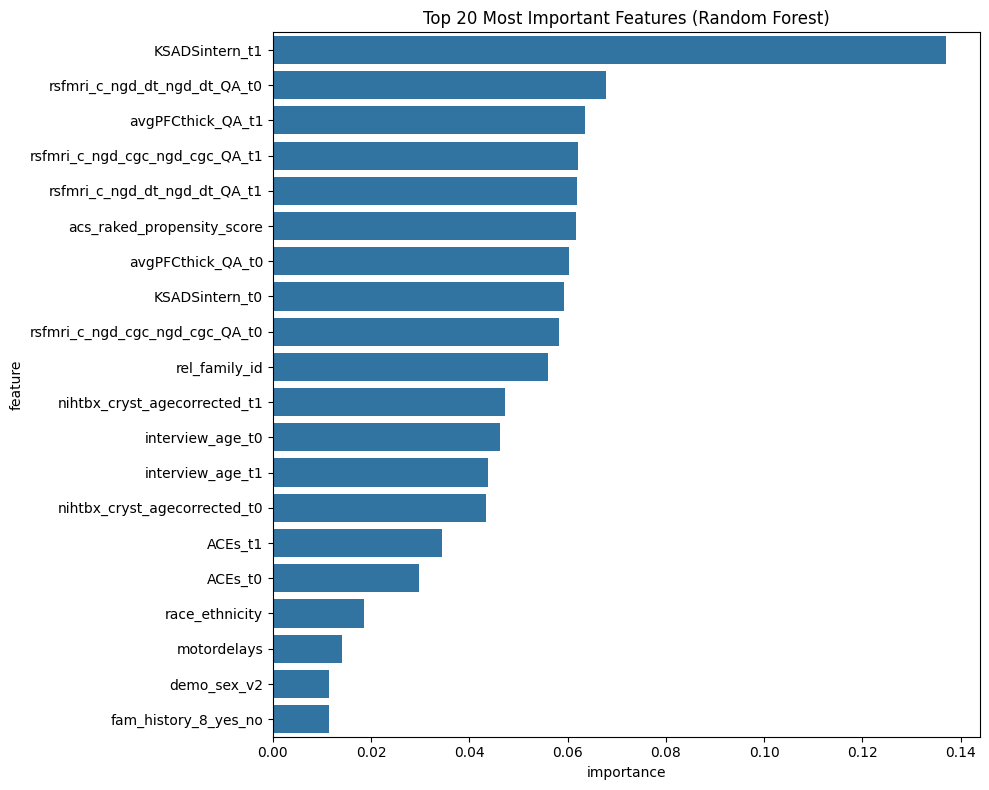

In [4]:
#just a model to predict the label using our features

X = df_renamed[flattened_features]
y = df_renamed['group_PDvLP_3timepoint']

tree = RandomForestClassifier(n_estimators=100, random_state=42)
tree.fit(X, y)

importances = tree.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title("Top 20 Most Important Features (Random Forest)")
plt.tight_layout()
save_path = '/content/drive/Shared drives/ABCD_Model/Explainability/feature_importance_label.png'
plt.savefig(save_path)  # saves the plot as PNG file
plt.show()



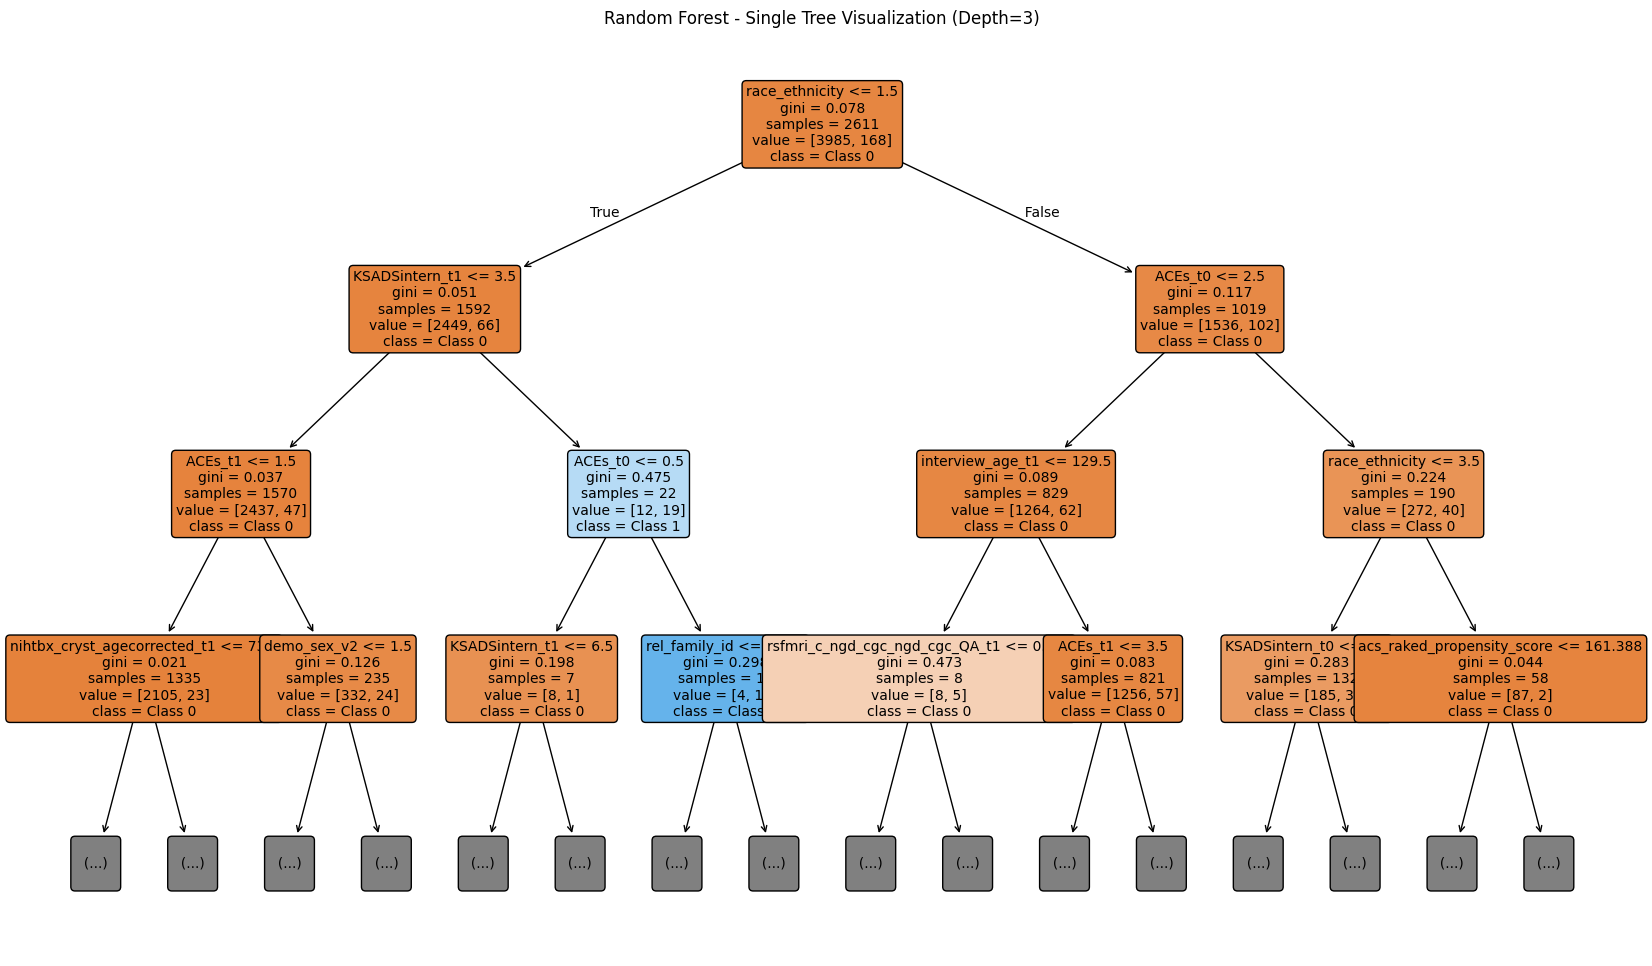

In [5]:
estimator = tree.estimators_[0]

plt.figure(figsize=(20, 12))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True,
    max_depth=3,  # limit depth to keep plot readable
    fontsize=10
)
plt.title("Random Forest - Single Tree Visualization (Depth=3)")
plt.show()


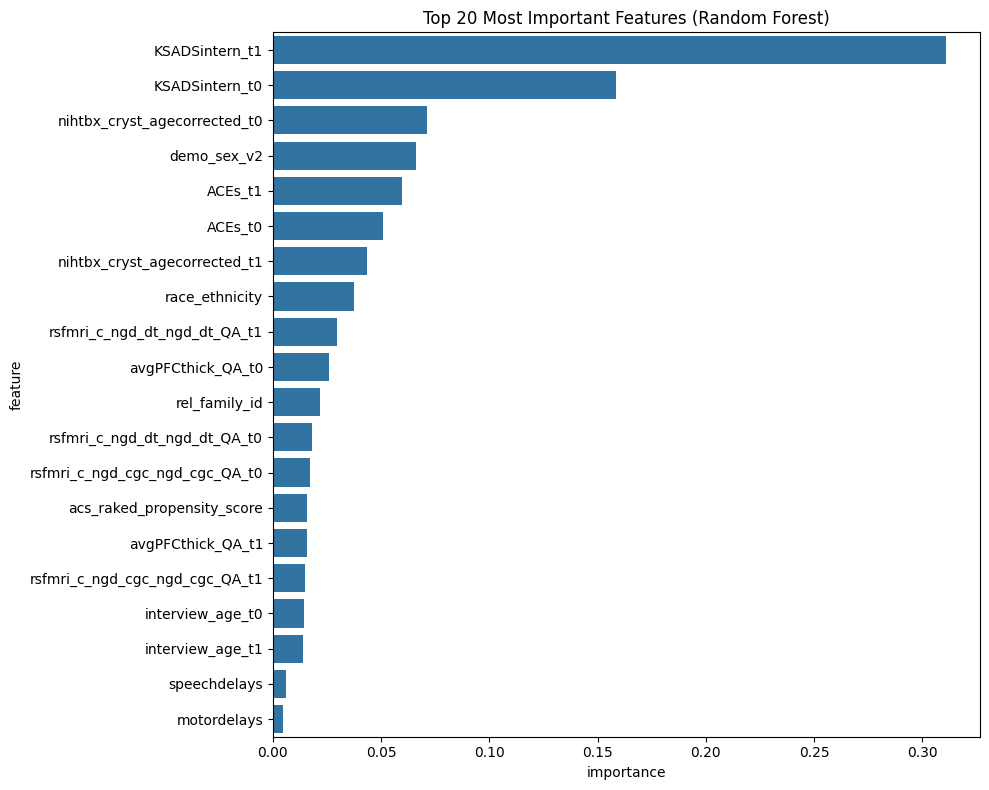

In [6]:
#This cell will predict probability values from our LSTM model. Trying to model LSTM using our features and seeing which feature is most important to
#mimicking our lstm predictions

predictions_file_path = '/content/drive/Shared drives/ABCD_Model/LSTM/LSTM_all_subject_predictions.csv'


preds_df = pd.read_csv(predictions_file_path)
merged_df = df_renamed.merge(preds_df[['src_subject_id', 'predicted_prob']], on='src_subject_id')

X = merged_df[flattened_features]
y = merged_df['predicted_prob']

tree = RandomForestRegressor(n_estimators=100, random_state=42)
tree.fit(X, y)
importances = tree.feature_importances_
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title("Top 20 Most Important Features (Random Forest)")
plt.tight_layout()
save_path = '/content/drive/Shared drives/ABCD_Model/Explainability/feature_importance_lstm_predictions.png'
plt.savefig(save_path)  # saves the plot as PNG file
plt.show()


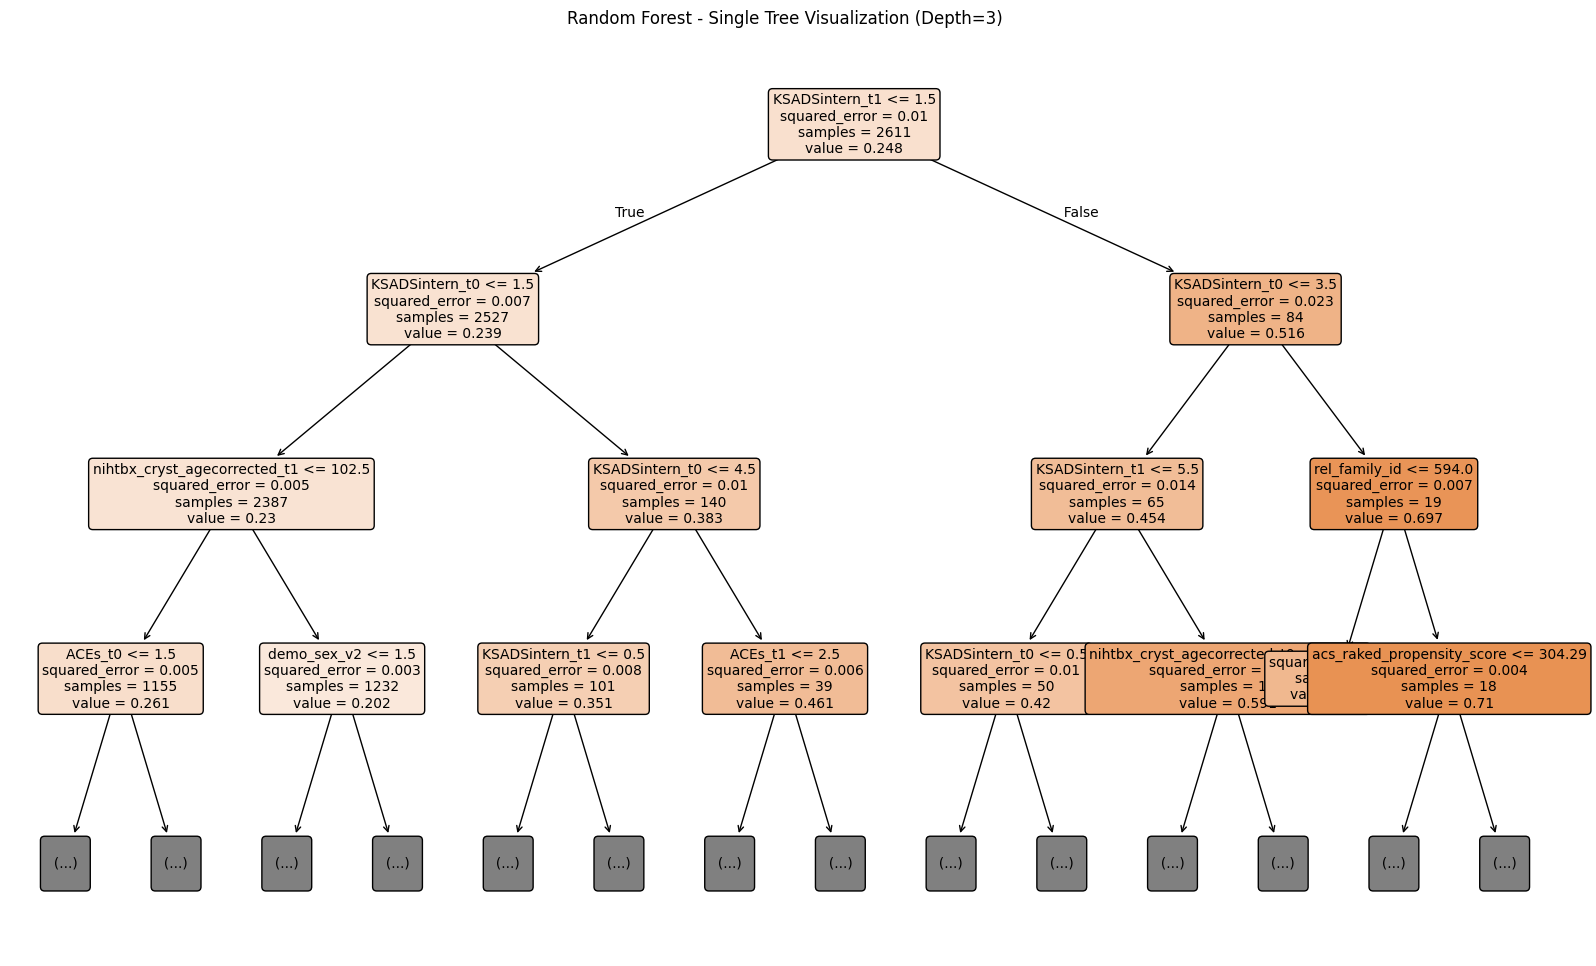

In [7]:
estimator = tree.estimators_[0]

plt.figure(figsize=(20, 12))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=['Class 0', 'Class 1'],
    filled=True,
    rounded=True,
    max_depth=3,  # limit depth to keep plot readable
    fontsize=10
)
plt.title("Random Forest - Single Tree Visualization (Depth=3)")
plt.show()
